# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
  1
  1
  1
  1
 -1
 -1
 -1
 -1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

### We create a function to visualize the data

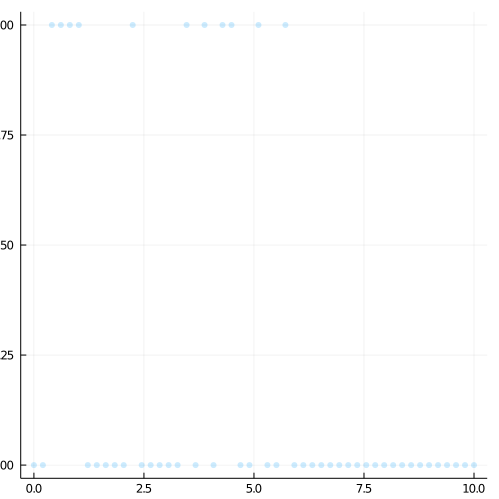

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.943424 seconds (1.87 M allocations: 106.824 MiB, 99.57% compilation time)


(Variational Gaussian Process with a Bernoulli Likelihood with Logistic Link infered by Analytic Variational Inference , (local_vars = (c = [0.7258779169976894, 0.6834624546781303, 0.6497353764314381, 0.6236843705610057, 0.6100670946061324, 0.6230778294156216, 0.6781854629491528, 0.7760679543778977, 0.8992840629430134, 1.0229172962967914  …  1.9609663843854461, 1.9544044811417225, 1.9392598793607334, 1.9126581945238736, 1.8713071347144248, 1.8125462779458497, 1.7354210950790916, 1.641521566564385, 1.5353351570654443, 1.4239287731424422], θ = [0.23957204756914938, 0.24070238481203646, 0.24156115485310153, 0.24219949032266458, 0.2425243197405441, 0.24221408891473276, 0.24083912175719796, 0.23816477533651317, 0.23441130985128675, 0.23026344808901453  …  0.19206729005599374, 0.19234816314495484, 0.19299672773822482, 0.19413687652965475, 0.19591089276927615, 0.1984331864276168, 0.20174038799421443, 0.20574927420782538, 0.2102378554279386, 0.21486579322622376]), opt_state = (NamedTuple(),), 

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:15
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:40
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:46
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:20
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:03
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:45
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:31
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:28
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:26
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.22975636425246565, 0.4012610072445188, 0.4915754036333156, 0.4775167278947015, 0.33896919164760037, 0.1721284106698649, -0.04862437334944904, -0.2787865078458225, -0.48869564459833376, -0.7119112143757701  …  -3.3554165755182366, -3.293871525967447, -3.2300849100386753, -3.1861790880445904, -3.1293197320591277, -2.9729305507980133, -2.788778382434544, -2.53332764368761, -2.2184796238252975, -1.7865744065801854]]
 [[-1.0829425820988687, -1.1696653409579933, -1.3078137745454352, -1.4222955395942665, -1.4589539769618287, -1.4746672738044744, -1.4386454646627302, -1.3652234625768231, -1.2564152863647915, -1.1730846395409833  …  -3.519711114248537, -3.3808405472871756, -3.115387612610755, -2.801248288637485, -2.475922202197318, -2.1218204074128293, -1.7420009966239642, -1.3724141740909381, -0.9738825422987372, -0.6147629514109253]]
 [[0.23312013683384544, 0.09018691547500399, -0.07567723653871335, -0.22358824401743474, -0.31851808424514805,

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

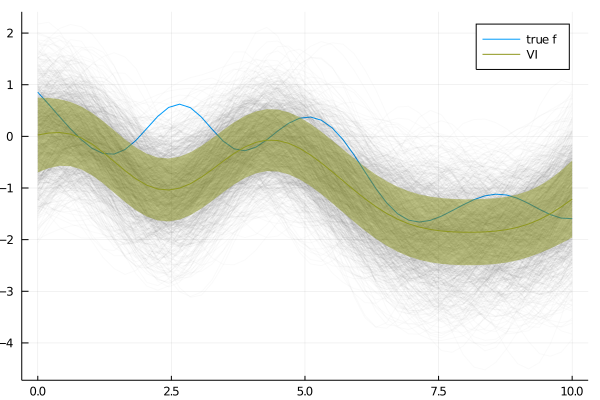

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

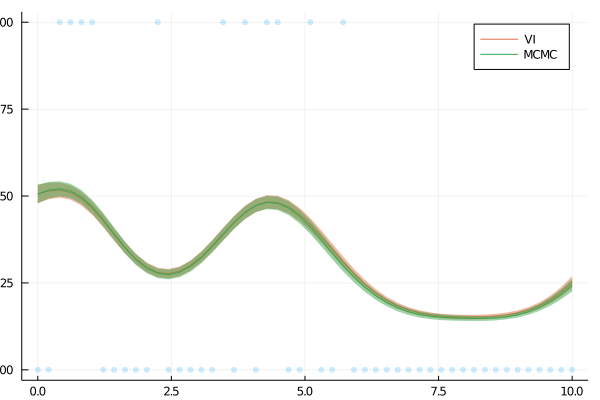

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*